# BBC News Classification Project
### Using Non-Negative Matrix Factorization to Train an Unsupervised Model and Comparing Results to A Supervised Model
### University of Colorado Boulder
DTSA 5510 

Unsupervised Learning

Spring 2024

Anna Sanders

## Importing Libraries

In [379]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import re
import string

# Modeling
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Text Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
# decision tree model

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# NLP
import spacy
nlp = spacy.load("en_core_web_sm")

## Load Data

In [349]:
data_test_x = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
data_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')

data = pd.concat([data_train, data_test_x])
data = data.reset_index()

# Data Exploration

In [305]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      2225 non-null   int64 
 1   ArticleId  2225 non-null   int64 
 2   Text       2225 non-null   object
 3   Category   1490 non-null   object
dtypes: int64(2), object(2)
memory usage: 69.7+ KB


We can see that the whole data (combined training and testing data) has very few columns. The ArticleId is the unique identifier of the article. The Text must be the full text of the article. The Category is then the labels of the articles.

In [306]:
print('Total Articles: ',len(data))
print('Training Observations: ', len(data_train))
print('Teest Observations: ', len(data_test_x))
print('Train Test Split: %.2f' %(len(data_test_x)/(len(data_train)+len(data_test_x))*100), '%')

Total Articles:  2225
Training Observations:  1490
Teest Observations:  735
Train Test Split: 33.03 %


In [308]:
print('Total Categories:', len(np.unique(data_train['Category'])))

Total Categories: 5


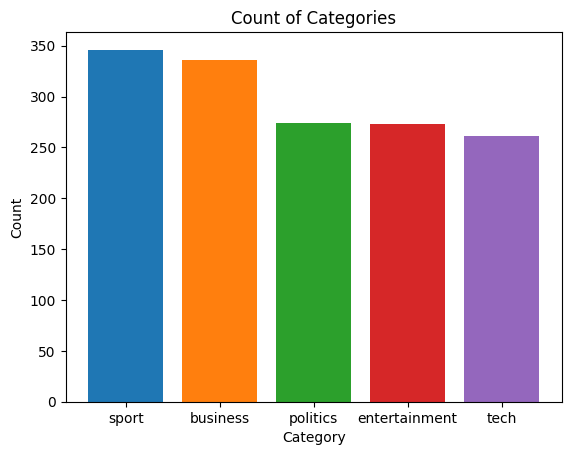

In [309]:
df = pd.DataFrame(data_train['Category'].value_counts()).reset_index()
fig, ax = plt.subplots()
ax.bar(df['Category'],df['count'], color=['tab:blue','tab:orange','tab:green','tab:red', 'tab:purple'])
ax.set_ylabel('Count')
ax.set_xlabel('Category')
ax.set_title('Count of Categories')
plt.show()

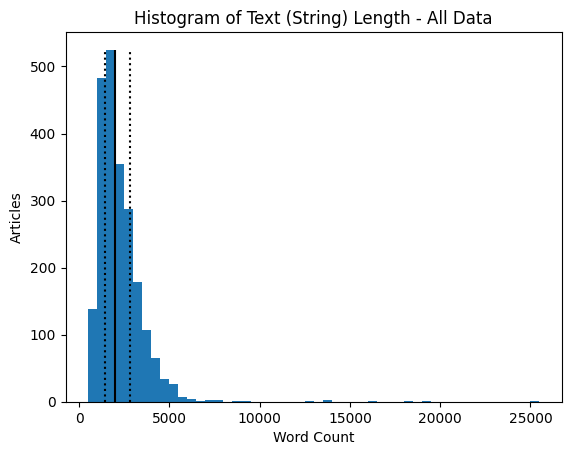

In [312]:
df = data
df['Text Count'] = df['Text'].apply(lambda x: len(x))
fig, ax = plt.subplots()
ax.hist(data['Text Count'], bins=50)
ax.set_ylabel('Articles')
ax.set_xlabel('Word Count')
ax.set_title('Histogram of Text (String) Length - All Data')
ax.vlines(df['Text Count'].quantile(0.5), 0, 525, color='black')
ax.vlines(df['Text Count'].quantile(0.25), 0, 525, color='black', linestyle='dotted')
ax.vlines(df['Text Count'].quantile(0.75), 0, 525, color='black', linestyle='dotted')
fig.show()

In [313]:
print('Median: ', df['Text Count'].quantile(0.5))
print('Q1: ', df['Text Count'].quantile(0.25))
print('Q3: ', df['Text Count'].quantile(0.75))

Median:  1965.0
Q1:  1446.0
Q3:  2802.0


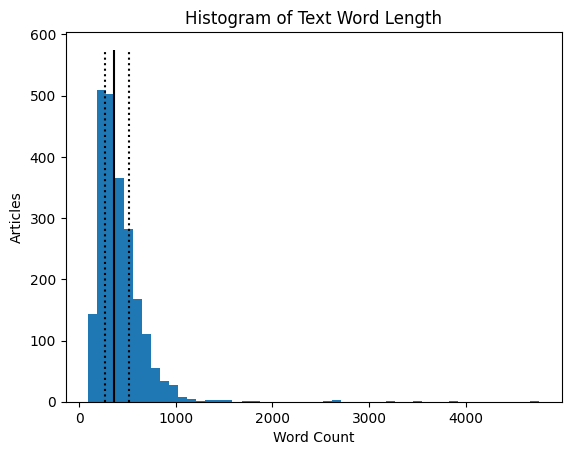

In [314]:
df = data
df['Word Count'] = df['Text'].apply(lambda x: len(x.split(sep=' ')))
fig, ax = plt.subplots()
ax.hist(data['Word Count'], bins=50)
ax.set_ylabel('Articles')
ax.set_xlabel('Word Count')
ax.set_title('Histogram of Text Word Length')
ax.vlines(df['Word Count'].quantile(0.5), 0, 575, color='black')
ax.vlines(df['Word Count'].quantile(0.25), 0, 575, color='black', linestyle='dotted')
ax.vlines(df['Word Count'].quantile(0.75), 0, 575, color='black', linestyle='dotted')
fig.show()

In [315]:
print('Median: ', df['Word Count'].quantile(0.5))
print('Q1: ', df['Word Count'].quantile(0.25))
print('Q3: ', df['Word Count'].quantile(0.75))

Median:  361.0
Q1:  268.0
Q3:  514.0


In [316]:
df = data_train
df['Text Count'] = df['Text'].apply(lambda x: len(x))
df['Word Count'] = df['Text'].apply(lambda x: len(x.split(sep=' ')))

df[['Category','Text Count', 'Word Count']].groupby('Category').mean()

,Text Count,Word Count
Category,,
business,1983.104167,357.913690
entertainment,1910.380952,360.531136
politics,2617.905109,484.135036
sport,1894.624277,361.667630
tech,2939.291188,538.122605


In [317]:
data.loc[0]['Text']

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

From the above plots and analysis, we can see that the overall categorization is fairly balanced. Most categories have at least 400 associated articles. The overall length of the text seems to be relatively small (string lengths less than 5,000 characters); however there are some outliers. Similarly, breaking the text down by assumed words (string split by sentences), most articles are less than 1,000 words. Looking at the averages of these values between categories, most seem to have around the same text and word count; however, both politics and tech have slightly more text/words per article than other categories. Looking at the first article, the text has been uncapatalized and some punctuation has been removed, like apostrophies. The first text also seems to contain many proper nouns as well.

# Data Cleaning and Text Processing

From the above results, we should modify or remove the instances of a singular 's', as the likely indicated a posessive apostrophe, which has now been removed. The letter 's' likely should not be parsed when processing text. We also want to remove potentially unnecessary words that wouldn't add value to determining the topic (category) of the article.

We can first load in the spaCy package, which is one of many python packages that do natural language processing, or turning words and sentences into vectors to relate words, sentences, and text through modeling. 

For this project, I loaded the pre-trained English language model. For the English language, spaCy has multiple models. The 'medium' model was chosen to ensure a balance of efficiency and accuracy.

Some NLP packages will allow the user or users to train the NLP pipeline or add and/or update the list of words that shouldn't be included in the text to vectorization process. We can first investigate the "en_core_web_sm" spaCy model.

In [108]:
print(len(nlp.Defaults.stop_words), list(nlp.Defaults.stop_words))

326 ['who', 'which', 'were', 'whereupon', 'of', 'when', 'beside', 'perhaps', 'seem', 'everywhere', 'few', 'even', 'him', 'hundred', 'yet', "n't", 'besides', 'four', 'anyway', 'otherwise', "'re", '’ve', 'under', 'go', 'before', 'therein', 'itself', 'nevertheless', 'wherever', 'further', 'show', 'serious', 'after', 'eleven', 'more', 'becomes', 'ours', 'front', 'why', 'whom', 'am', 'amount', 'do', 'amongst', 'five', 'side', 'because', 'fifteen', 'not', 'me', 'hers', 'own', 'every', 'put', 'above', 'anywhere', 'if', 'thereby', 'though', 'my', 'bottom', 'should', 'whoever', 'quite', 'none', 'ca', 'we', 'may', 'back', 'whose', 'toward', 'also', '’d', 'too', 'as', 'i', 'around', 'hence', 'enough', 'beyond', '‘re', 'how', 'does', "'m", 'always', 'out', 'those', '‘ll', 'less', 'into', 'another', 'no', 'now', 'cannot', '‘d', 'first', 'afterwards', 'regarding', 'since', 'others', 'but', 'upon', 'hereupon', 'only', 'namely', 'herself', '‘ve', 'behind', '’ll', 'these', 'see', 'and', 'nine', 'done',

The model has a list of 326 default stop words. In the stop words is 's, which means that it is likely better if we remove the single s in the text instead of removing the space or adding back in an apostrophe. We should similarly remove single t's, single d's, single m's, double ll's, re's, and ve's (which also exists as a stop word in the list without an apostrophe). We should also remove any instaces of a double space, as that is also not helpful to keep in the text.

In [318]:
data_train_clean = data_train.copy()
data_test_clean = data_test_x.copy()
data_train_clean['Text'] = data_train_clean['Text'].apply(lambda x: x.replace(' s ', ' '))
data_test_clean['Text'] = data_test_clean['Text'].apply(lambda x: x.replace(' s ', ' '))
data_train_clean['Text'] = data_train_clean['Text'].apply(lambda x: x.replace(' t ', ' '))
data_test_clean['Text'] = data_test_clean['Text'].apply(lambda x: x.replace(' t ', ' '))
data_train_clean['Text'] = data_train_clean['Text'].apply(lambda x: x.replace(' d ', ' '))
data_test_clean['Text'] = data_test_clean['Text'].apply(lambda x: x.replace(' d ', ' '))
data_train_clean['Text'] = data_train_clean['Text'].apply(lambda x: x.replace(' m ', ' '))
data_test_clean['Text'] = data_test_clean['Text'].apply(lambda x: x.replace(' m ', ' '))
data_train_clean['Text'] = data_train_clean['Text'].apply(lambda x: x.replace(' ll ', ' '))
data_test_clean['Text'] = data_test_clean['Text'].apply(lambda x: x.replace(' ll ', ' '))
data_train_clean['Text'] = data_train_clean['Text'].apply(lambda x: x.replace(' ve ', ' '))
data_test_clean['Text'] = data_test_clean['Text'].apply(lambda x: x.replace(' ve ', ' '))
data_train_clean['Text'] = data_train_clean['Text'].apply(lambda x: x.replace('  ', ' '))
data_test_clean['Text'] = data_test_clean['Text'].apply(lambda x: x.replace('  ', ' '))
data_test_clean.loc[0]['Text']

'qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month loan. day has been displaced by the arrival of simon royce who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r manager ian holloway said: some might say it a risk as he can be recalled during that month and simon royce can now be recalled by charlton. but i have other irons in the fire. i have had a yes from a couple of others should i need them.  day rangers contract expires in the summer. meanwhile holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.'

We can also remove the list of stop words and leftover punctuation from the text.

In [319]:
data_train_clean['Text'] = data_train_clean['Text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
data_test_clean['Text'] = data_test_clean['Text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))

def remove_words(text):
    doc = nlp(text)
    n_text = [word.text for word in doc if (word not in nlp.Defaults.stop_words)] #word.text forces back to string
    return ' '.join(n_text) #forces back to full text

# takes a bit of time
data_train_clean['Text'] = data_train_clean['Text'].apply(remove_words)
data_test_clean['Text'] = data_test_clean['Text'].apply(remove_words)
    
print(data_test_clean.loc[0]['Text'])

qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month loan day has been displaced by the arrival of simon royce who is in his second month on loan from charlton qpr have also signed italian generoso rossi r manager ian holloway said some might say it a risk as he can be recalled during that month and simon royce can now be recalled by charlton but i have other irons in the fire i have had a yes from a couple of others should i need them   day rangers contract expires in the summer meanwhile holloway is hoping to complete the signing of middlesbrough defender andy davies   either permanently or again on loan   before saturday match at ipswich davies impressed during a recent loan spell at loftus road holloway is also chasing bristol city midfielder tom doherty


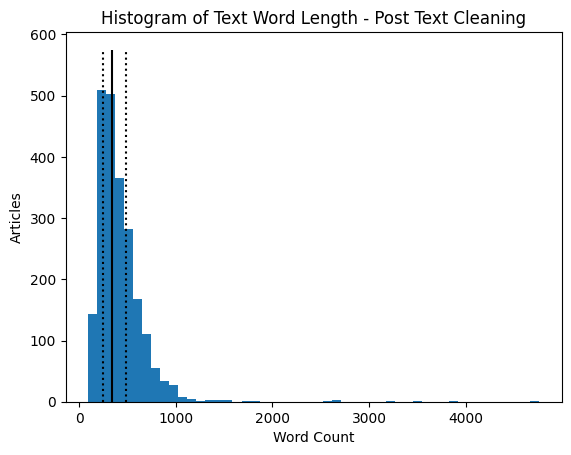

In [320]:
data_clean = pd.concat([data_test_clean, data_train_clean])
data_clean = data_clean.reset_index()
df = data_clean

df['Word Count'] = df['Text'].apply(lambda x: len(x.split(sep=' ')))
fig, ax = plt.subplots()
ax.hist(data['Word Count'], bins=50)
ax.set_ylabel('Articles')
ax.set_xlabel('Word Count')
ax.set_title('Histogram of Text Word Length - Post Text Cleaning')
ax.vlines(df['Word Count'].quantile(0.5), 0, 575, color='black')
ax.vlines(df['Word Count'].quantile(0.25), 0, 575, color='black', linestyle='dotted')
ax.vlines(df['Word Count'].quantile(0.75), 0, 575, color='black', linestyle='dotted')
fig.show()

In [321]:
print('Median: ', df['Word Count'].quantile(0.5))
print('Q1: ', df['Word Count'].quantile(0.25))
print('Q3: ', df['Word Count'].quantile(0.75))

Median:  340.0
Q1:  251.0
Q3:  482.0


We can see that the overall removal of stop words did not significantly decrease the overall words in the text.

# Text Vectorization

We are ready to vectorize the cleaned text. The sklearn package comes with a TF-IDF function that converts a collection of raw documents, in this case, the cleaned text column from our train and  test data, and converts it into a matrix of TF-IDF features. 

TF-IDF is a measure of the importance of words to a document, adjusted for frequent words. Higher values indicate that the word is more relevant to a text. TF-IDF is similar to the bag of words method, but normalizes the word based on frequency in other texts.

With Non-Negative Matrix Factorization in mind, TF-IDF is useful because the results are strictly positive. We can then feed the created matrix into the non-negative matrix factorization function.

If the only data we had was the 'BBC News Train' data, we should split the data into training and testing sets and 'train' the unsupervised model on it. However; since we do have a 'Test' set, we can take the split at face value and use the listed training and testing data as such. 

The number of features was chosen to capture a large amount of the potnetial words in the articles, but not large enough to impact preformance.  

In [322]:
tfidf = TfidfVectorizer(max_df = 0.95, min_df=2, max_features=2000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(np.array(data_train_clean['Text']))

# Non-Negative Matrix Factorization
With the tfidf matrix created, we can now run the non-negative matrix factorization. We know from the data that there are 5 categories, so we can set the number of components to 5. For now, we can leave all the other hyperparameters as the model's default. Since this is unsupervised learning, we can run the model on all available data and compare the results to the known labels.

In [326]:
nmf = NMF(n_components=5, random_state=1)
nmf.fit(tfidf_matrix)
W = nmf.fit_transform(tfidf_matrix)
H = nmf.components_

We can now look at what words the model has found to be most important, knowing there are 5 topics in total.

In [327]:
# code adapted from sklearn's Topic extraction with Non-negative Matrix Factorization and Latent 
# Dirichelet Allocation (see resources below)
n_top_words = 10
model_feature_df = pd.DataFrame(columns=['Topic','Word','Weight'])

for topic_idx, topic in enumerate(nmf.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = tfidf.get_feature_names_out()[top_features_ind]
        weights = topic[top_features_ind]
        d = {'Topic': [topic_idx]*n_top_words, 'Word':top_features, 'Weight':weights}
        d = pd.DataFrame(d)
        model_feature_df = pd.concat([model_feature_df,d])
        print('Topic: ', topic_idx, 'Words: ', top_features)

Topic:  0 Words:  ['france' 'play' 'players' 'said' 'cup' 'ireland' 'wales' 'win' 'game'
 'england']
Topic:  1 Words:  ['prime' 'minister' 'government' 'said' 'party' 'brown' 'election' 'blair'
 'labour' 'mr']
Topic:  2 Words:  ['phones' 'software' 'users' 'digital' 'technology' 'phone' 'said' 'music'
 'mobile' 'people']
Topic:  3 Words:  ['director' 'won' 'festival' 'films' 'actress' 'actor' 'award' 'awards'
 'best' 'film']
Topic:  4 Words:  ['economic' '2004' 'oil' 'bank' 'market' 'sales' 'year' 'economy' 'growth'
 'said']


Looking at this list, it seems like the topics have found promising words! Topic 0 looks to be related to sports; as the BBC is an UK based paper, it isn't suprising that the topic has found words like 'match' and 'club,' likely talking about football (American soccer) and words like 'england' and 'wales' which are regions in the UK. Topic 1 looks to be assoicated with politics, while topic 2 sounds like business news. Topic 3 has words associated with mostly films, but potentially entertainment in general, and topic 4 has words associated with technology.

## Choosing the Most Likely Cateogry
We can look at the W matrix in order to determine the category with the highest value, or the most likely category for the text/article.

In [330]:
cat = []
for i in range(len(W)):
    cat.append(max(enumerate(W[i]), key=lambda x:x[1])[0])
    
data_train_clean['Predicted Category'] = cat
data_train_clean

,ArticleId,Text,Category,Text Count,Word Count,Predicted Category
0,1833,worldcom exboss launches defence lawyers defen...,business,1866,324,4
1,154,german business confidence slides german busin...,business,2016,348,4
2,1101,bbc poll indicates economic gloom citizens in ...,business,3104,551,4
3,1976,lifestyle governs mobile choice faster better ...,tech,3618,692,2
4,917,enron bosses in 168 m payout eighteen former e...,business,2190,381,4
...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1266,237,3
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,3111,619,2
1487,1590,weak dollar hits reuters revenues at media gro...,business,1370,252,4
1488,1587,apple ipod family expands market apple has exp...,tech,3242,595,2


We now need to associate the predicted numeric category with the best actually labeled category and relabel the predicted classes for easy metric calculations.

In [331]:
# Code copied from Week 2 Assignment
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    ytdf = np.array(ytdf).reshape(1,len(ytdf))[0]
    
    o_labels = np.unique(ytdf)
    n_labels = np.unique(yp)
    b_labels = []
    f_label = []
    u_label = []
    for i in o_labels:
        max_label_max = float('-inf')
        max_label = None
        for j in n_labels:
            count = 0
            l_count = 0
            for n in range(len(ytdf)):
                if (ytdf[n] == i) and (yp[n] == j):
                    l_count += 1
                    count += 1
                if (ytdf[n] == i) and (yp[n] != j):
                    count += 1
#             print(j, max_label_max, float(l_count/count))
            if ((l_count/count) > max_label_max):
                if j in u_label:
                    continue
                max_label_max = float(l_count/count)
                max_label = ([i,j],[l_count, count])
        u_label.append(max_label[0][1])
        b_labels.append(max_label)
    t_count = 0
    t_ccount = 0
    for i in b_labels:
        f_label.append(i[0])
        t_ccount += i[1][0]
        t_count += i[1][1]
        
    return (f_label,(t_ccount/t_count))

In [332]:
pred_labels = label_permute_compare(data_train_clean['Category'].values, data_train_clean['Predicted Category'].values)
print(pred_labels)

pred_labels_lst = [None] * len(pred_labels[0])
for i in pred_labels[0]:
    pred_labels_lst[i[1]] = i[0]

data_clean_nmf1 = data_train_clean.copy()

for i in pred_labels[0]:
    data_clean_nmf1.loc[data_clean_nmf1['Predicted Category'] == i[1], 'Predicted Category'] = i[0]

data_clean_nmf1

([['business', 4], ['entertainment', 3], ['politics', 1], ['sport', 0], ['tech', 2]], 0.9154362416107382)


,ArticleId,Text,Category,Text Count,Word Count,Predicted Category
0,1833,worldcom exboss launches defence lawyers defen...,business,1866,324,business
1,154,german business confidence slides german busin...,business,2016,348,business
2,1101,bbc poll indicates economic gloom citizens in ...,business,3104,551,business
3,1976,lifestyle governs mobile choice faster better ...,tech,3618,692,tech
4,917,enron bosses in 168 m payout eighteen former e...,business,2190,381,business
...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1266,237,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,3111,619,tech
1487,1590,weak dollar hits reuters revenues at media gro...,business,1370,252,business
1488,1587,apple ipod family expands market apple has exp...,tech,3242,595,tech


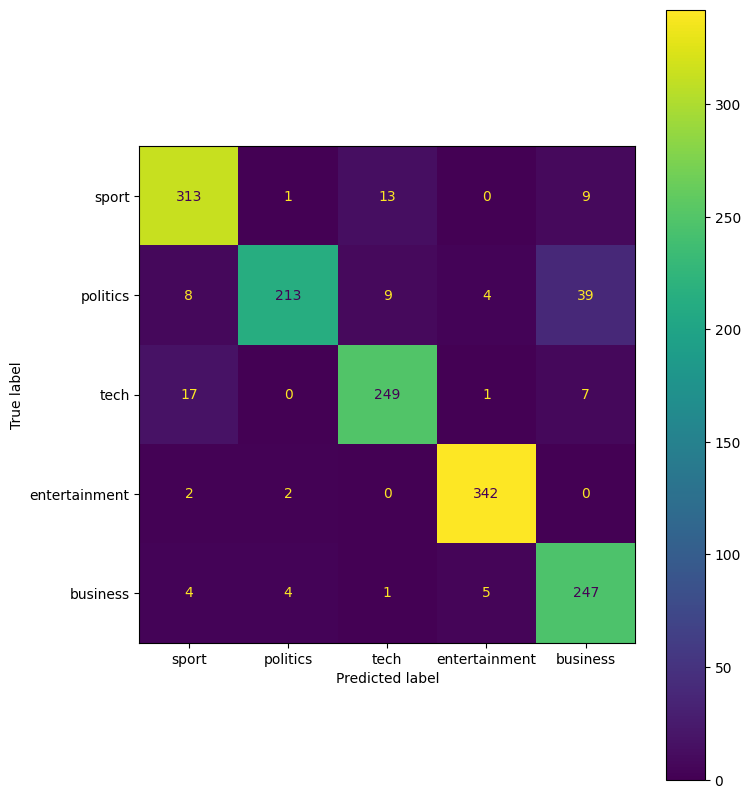

In [333]:
cf = confusion_matrix(data_clean_nmf1['Category'].values, data_clean_nmf1['Predicted Category'].values)

cmd = ConfusionMatrixDisplay(cf, display_labels = pred_labels_lst)
fig, ax = plt.subplots(figsize=(8,10))
cmd.plot(ax=ax)

In [334]:
print('Accuracy: %.3f' %(accuracy_score(data_clean_nmf1['Category'].values, data_clean_nmf1['Predicted Category'].values)))
print('Precision: %.3f' %(precision_score(data_clean_nmf1['Category'].values, data_clean_nmf1['Predicted Category'].values, average='weighted')))
print('Recall: %.3f' %(recall_score(data_clean_nmf1['Category'].values, data_clean_nmf1['Predicted Category'].values, average='weighted')))
print('F1: %.3f' %(f1_score(data_clean_nmf1['Category'].values, data_clean_nmf1['Predicted Category'].values, average='weighted')))


Accuracy: 0.915
Precision: 0.920
Recall: 0.915
F1: 0.915


The non-negative matrix factorization performs very well. With an overall accuracy of 0.915, or 92%, this is a relatively well trained model. In the confusion matrix, we see that political articles are often misclassifed as business. We can also see that some articles are misclassified as sports.

We can now try various hyperparameters in nmf to find the best model.

([['business', 1], ['entertainment', 2], ['politics', 0], ['sport', 4], ['tech', 3]], 0.8986577181208054)
Combination:  {'beta_loss': 'frobenius', 'init': 'random', 'solver': 'mu'}
Accuracy: 0.899
Precision: 0.904
Recall: 0.899
F1: 0.897
([['business', 4], ['entertainment', 3], ['politics', 1], ['sport', 0], ['tech', 2]], 0.9107382550335571)
Combination:  {'beta_loss': 'frobenius', 'init': 'nndsvdar', 'solver': 'mu'}
Accuracy: 0.911
Precision: 0.916
Recall: 0.911
F1: 0.910
([['business', 1], ['entertainment', 4], ['politics', 2], ['sport', 0], ['tech', 3]], 0.9449664429530201)
Combination:  {'beta_loss': 'kullback-leibler', 'init': 'random', 'solver': 'mu'}
Accuracy: 0.945
Precision: 0.947
Recall: 0.945
F1: 0.945
([['business', 4], ['entertainment', 3], ['politics', 1], ['sport', 0], ['tech', 2]], 0.9496644295302014)
Combination:  {'beta_loss': 'kullback-leibler', 'init': 'nndsvdar', 'solver': 'mu'}
Accuracy: 0.950
Precision: 0.952
Recall: 0.950
F1: 0.950


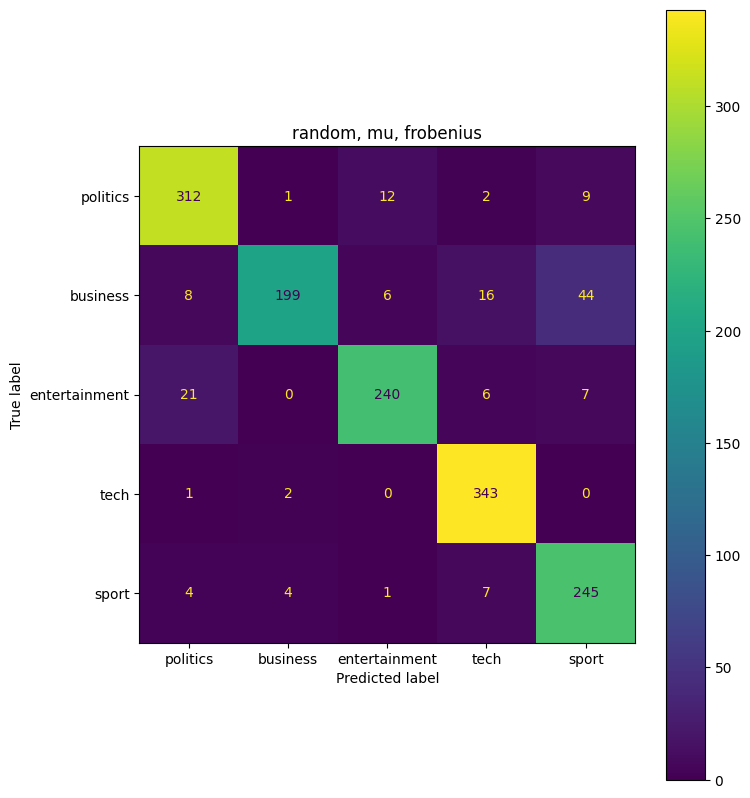

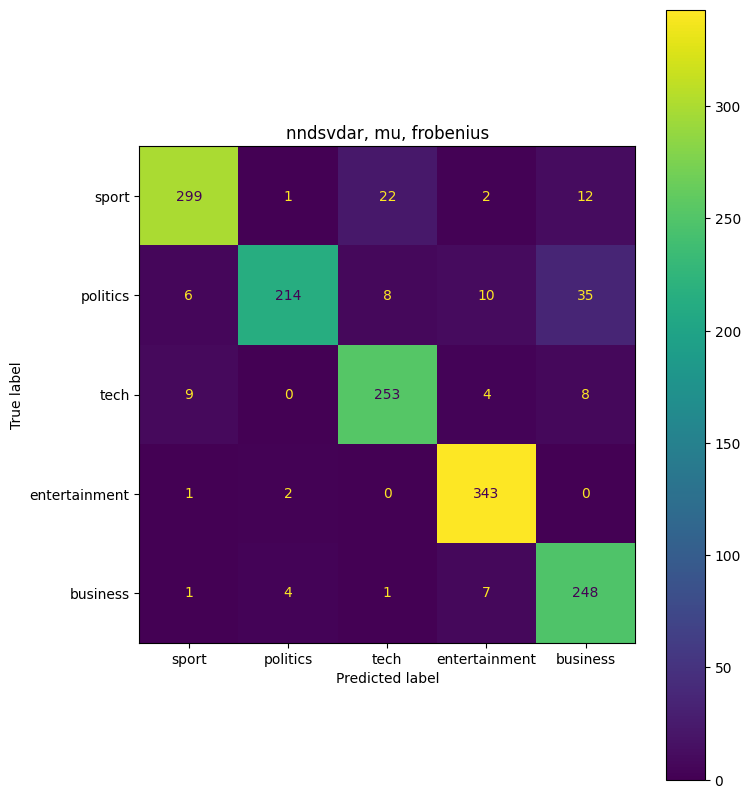

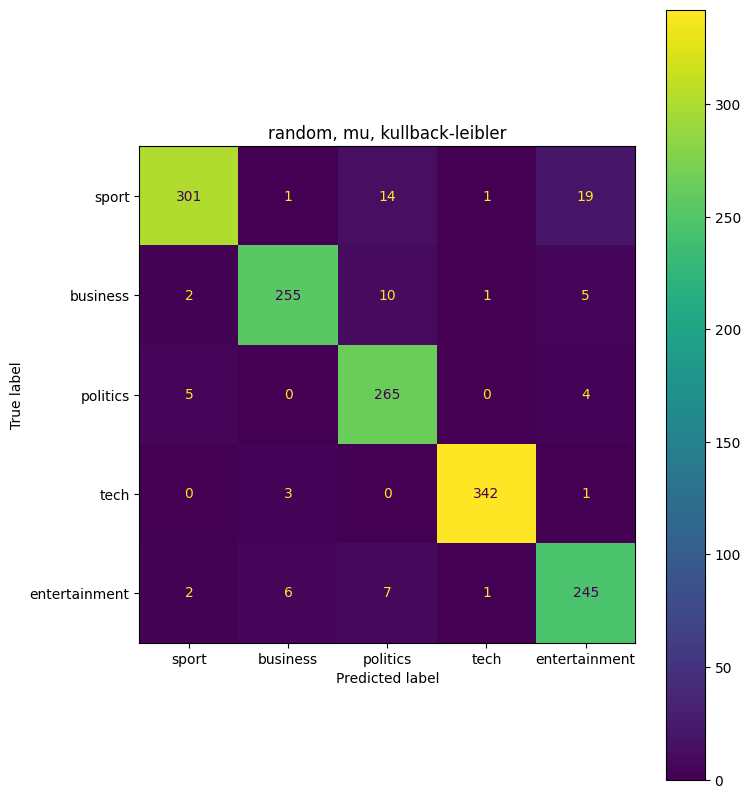

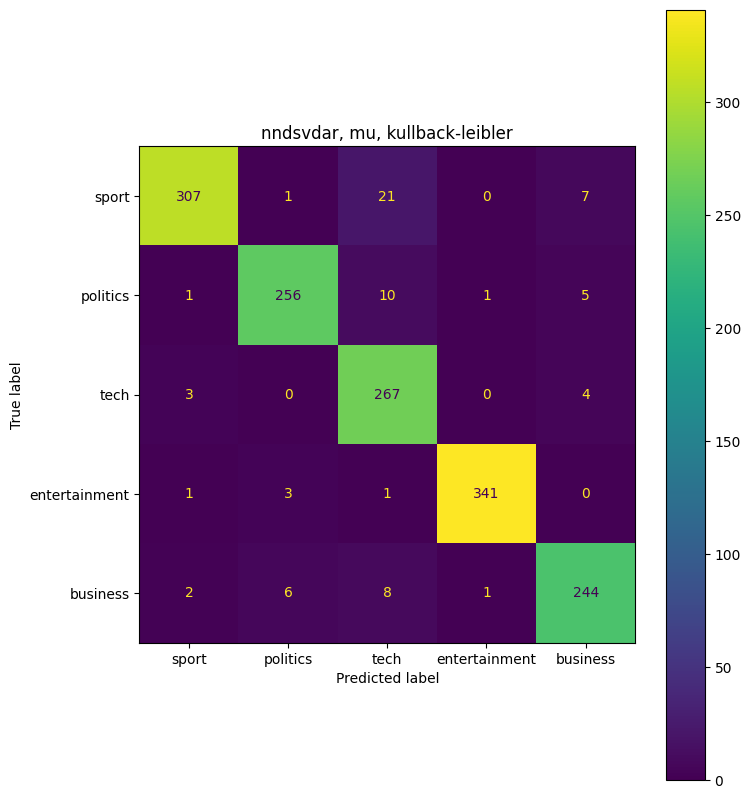

In [335]:
params = {'init':['random','nndsvdar'], 'solver':['mu'], 'beta_loss':['frobenius','kullback-leibler']}
pgrid_dict = list(ParameterGrid(params))

for hyp in pgrid_dict:
    nmf = NMF(n_components=5, random_state=1, init=hyp.get('init'), solver=hyp.get('solver'), beta_loss=hyp.get('beta_loss'))
    nmf.fit(tfidf_matrix)
    W = nmf.fit_transform(tfidf_matrix)

    cat = []
    for i in range(len(W)):
        cat.append(max(enumerate(W[i]), key=lambda x:x[1])[0])

    data_train_clean['Predicted Category'] = cat

    pred_labels = label_permute_compare(data_train_clean['Category'].values, data_train_clean['Predicted Category'].values)
    print(pred_labels)

    pred_labels_lst = [None] * len(pred_labels[0])
    for i in pred_labels[0]:
        pred_labels_lst[i[1]] = i[0]

    data_clean_nmf2 = data_train_clean.copy()

    for i in pred_labels[0]:
        data_clean_nmf2.loc[data_clean_nmf2['Predicted Category'] == i[1], 'Predicted Category'] = i[0]

    cf = confusion_matrix(data_clean_nmf2['Category'].values, data_clean_nmf2['Predicted Category'].values)

    cmd = ConfusionMatrixDisplay(cf, display_labels = pred_labels_lst)
    fig, ax = plt.subplots(figsize=(8,10))
    ax.set_title(str(hyp.get('init')) + ', ' + str(hyp.get('solver')) + ', ' + str(hyp.get('beta_loss')))
    cmd.plot(ax=ax)
    
    print('Combination: ', hyp)
    print('Accuracy: %.3f' %(accuracy_score(data_clean_nmf2['Category'].values, data_clean_nmf2['Predicted Category'].values)))
    print('Precision: %.3f' %(precision_score(data_clean_nmf2['Category'].values, data_clean_nmf2['Predicted Category'].values, average='weighted')))
    print('Recall: %.3f' %(recall_score(data_clean_nmf2['Category'].values, data_clean_nmf2['Predicted Category'].values, average='weighted')))
    print('F1: %.3f' %(f1_score(data_clean_nmf2['Category'].values, data_clean_nmf2['Predicted Category'].values, average='weighted')))

The highest combination ({'beta_loss': 'kullback-leibler', 'init': 'nndsvdar', 'solver': 'mu'}) had an accuracy of 0.95, or 95%. This is an improvement from the first non-negative matrix factorization model that we ran. Overall 95% accuraccy is very good.

# Supervised Learning (Clustering)
We will now use the split given training data into a usable train-test split and train various supervised learning models. We make sure not to fit the testing data in the TF-IDF vectorizer; only the training data should be vectorized, and the testing data should be vectorized from the training fit to not take into account 'future' results.

In [430]:
tfidf = TfidfVectorizer(max_df = 0.95, min_df=2, max_features=2000, stop_words='english')

train, test = train_test_split(data_train_clean, test_size=0.3, shuffle=True, random_state=1)

train_x = tfidf.fit_transform((train['Text']))
test_x = tfidf.transform((test['Text']))

y_train = train['Category'].values
y_test = test['Category'].values

In [422]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier

In [423]:
svc_model = LinearSVC()
knn_model = KNeighborsClassifier()
sgd_model = SGDClassifier()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
rg_model = RidgeClassifier()
lg_model = LogisticRegression()

svc_model.fit(train_x,y_train)
knn_model.fit(train_x,y_train)
sgd_model.fit(train_x,y_train)
dt_model.fit(train_x,y_train)
rf_model.fit(train_x,y_train)
rg_model.fit(train_x, y_train)
lg_model.fit(train_x, y_train)

svc_predict = svc_model.predict(test_x)
knn_predict =  knn_model.predict(test_x)
sgd_predict =  sgd_model.predict(test_x)
dt_predict = dt_model.predict(test_x)
rf_predict = rf_model.predict(test_x)
rg_predict = rg_model.predict(test_x)
lg_predict = lg_model.predict(test_x)

print('SVC Accuracy: %.3f' %(accuracy_score(y_test, svc_predict)))
print('KNN Accuracy: %.3f' %(accuracy_score(y_test, knn_predict)))
print('SGD Accuracy: %.3f' %(accuracy_score(y_test, sgd_predict)))
print('DT Accuracy: %.3f' %(accuracy_score(y_test, dt_predict)))
print('RF Accuracy: %.3f' %(accuracy_score(y_test, rf_predict)))
print('RG Accuracy: %.3f' %(accuracy_score(y_test, rg_predict)))
print('LG Accuracy: %.3f' %(accuracy_score(y_test, rg_predict)))

SVC Accuracy: 0.980
KNN Accuracy: 0.924
SGD Accuracy: 0.980
DT Accuracy: 0.801
RF Accuracy: 0.957
RG Accuracy: 0.982
LG Accuracy: 0.982


From the above models, it looks like the Ridge Classifier or the Logistic Regression fit the data best with not hyperparameter changes. Most models, except for the KNN and Decision Tree model, preform better than the Non-negative Matrix Factorization. We can take a closer look at the two models below.

RG CV Scores:  [0.94285714 0.98095238 0.96190476 0.97115385 0.95192308 0.95192308
 0.99038462 0.96153846 0.98076923 0.97115385]
LG CV Scores:  [0.93333333 0.98095238 0.97142857 0.98076923 0.96153846 0.95192308
 0.98076923 0.93269231 0.95192308 0.96153846]


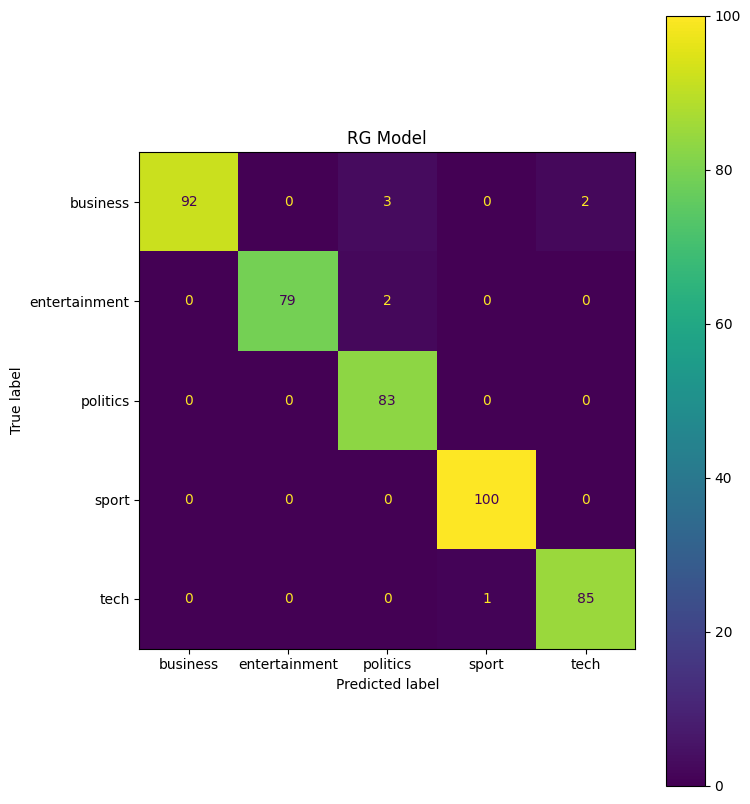

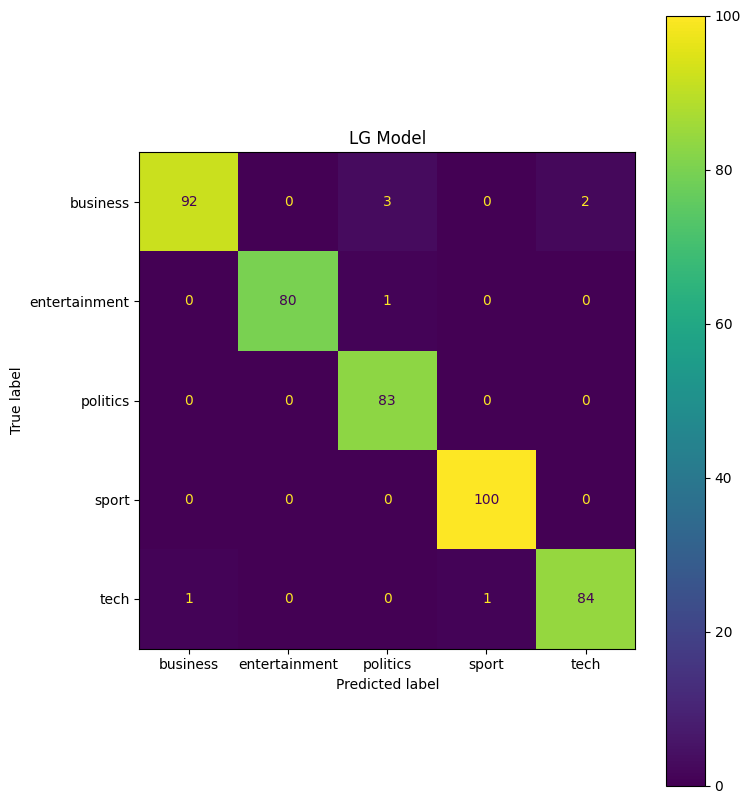

In [364]:
cv_scores = cross_val_score(rg_model, train_x,y_train, cv=10, scoring='accuracy')
print('RG CV Scores: ',cv_scores)
cv_scores = cross_val_score(lg_model, train_x,y_train, cv=10, scoring='accuracy')
print('LG CV Scores: ',cv_scores)

cf = confusion_matrix(y_test, rg_predict)
cmd = ConfusionMatrixDisplay(cf, display_labels = rg_model.classes_)
fig, ax = plt.subplots(figsize=(8,10))
ax.set_title('RG Model')
cmd.plot(ax=ax)

cf = confusion_matrix(y_test, lg_predict)
cmd = ConfusionMatrixDisplay(cf, display_labels = lg_model.classes_)
fig, ax = plt.subplots(figsize=(8,10))
ax.set_title('LG Model')
cmd.plot(ax=ax)

The cross validation scores for both models look good, so there does not seem to be any overfitting in the model. Looking at the confusion matrix, the LG model seems to predict entertainment models more accurately, while the RG model classifies tech articles more accurately.

For our best models, we can now test how changign the test size effects model accuracy.

In [426]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    train, test = train_test_split(data_train_clean, test_size=i, shuffle=True, random_state=1)

    train_x = tfidf.fit_transform((train['Text']))
    test_x = tfidf.transform((test['Text']))

    y_train = train['Category'].values
    y_test = test['Category'].values
    
    rg_model = RidgeClassifier()
    lg_model = LogisticRegression()
    
    rg_model.fit(train_x, y_train)
    lg_model.fit(train_x, y_train)
    
    rg_predict = rg_model.predict(test_x)
    lg_predict = lg_model.predict(test_x)
    
    print(str(i),' Test Size RG Accuracy: %.3f' %(accuracy_score(y_test, rg_predict)))
    print(str(i),' Test Size LG Accuracy: %.3f' %(accuracy_score(y_test, rg_predict)))
    

0.1  Test Size RG Accuracy: 0.980
0.1  Test Size LG Accuracy: 0.980
0.2  Test Size RG Accuracy: 0.980
0.2  Test Size LG Accuracy: 0.980
0.3  Test Size RG Accuracy: 0.982
0.3  Test Size LG Accuracy: 0.982
0.4  Test Size RG Accuracy: 0.977
0.4  Test Size LG Accuracy: 0.977
0.5  Test Size RG Accuracy: 0.974
0.5  Test Size LG Accuracy: 0.974
0.6  Test Size RG Accuracy: 0.969
0.6  Test Size LG Accuracy: 0.969
0.7  Test Size RG Accuracy: 0.968
0.7  Test Size LG Accuracy: 0.968


Interestingly enough, the split of 30% to training data had the highest accuracy. The accuracy didn't fall off as much as I expected, as at 70% of the data withheld for testing, the model was still more accurate than the Non-negative Matrix Factorization.

In [431]:
params = {'penalty':['l2'], 'C':[0.5,1,1.5,2,2.5,3], 'class_weight':[None, 'balanced'], 'solver':['sag','lbfgs','saga']}
lg_model_gs = LogisticRegression(random_state=1, max_iter=500)
gs = GridSearchCV(lg_model_gs,params)
gs.fit(train_x, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=500, random_state=1),
             param_grid={'C': [0.5, 1, 1.5, 2, 2.5, 3],
                         'class_weight': [None, 'balanced'], 'penalty': ['l2'],
                         'solver': ['sag', 'lbfgs', 'saga']})

In [432]:
print(gs.best_estimator_)
print(gs.best_score_)

LogisticRegression(C=3, class_weight='balanced', max_iter=500, random_state=1,
                   solver='saga')
0.9645334928229665


In [433]:
lg_model_best = LogisticRegression(C=1, class_weight='balanced', solver='sag', random_state=1, max_iter=500)
lg_model_best.fit(train_x, y_train)
y_pred = lg_model_best.predict(test_x)
print('Accuracy: %.3f' %(accuracy_score(y_test, y_pred)))

Accuracy: 0.980


# Final Predictions
We can now predict the labels on the project's testing data set. We will Choose the Logistic Model and re-train the entire labeled data set.

Oddly enough, through multiple submissions, the model seems to overfit when fed too much training data. The lg model referenced below is actually the model fit to only 30% of the training data.

In [366]:
final_test_x = tfidf.transform(data_test_clean['Text'])

In [427]:
train_x_final = tfidf.fit_transform((data_train_clean['Text']))
y_train_final = data_train_clean['Category'].values

# lg_model = LogisticRegression(C=1, class_weight='balanced', solver='sag', random_state=1, max_iter=500)
# lg_model.fit(train_x_final, y_train_final)
final_test_pred = lg_model.predict(final_test_x)

In [428]:
final_pred_df = data_test_clean['ArticleId'].copy()
final_pred_df = pd.DataFrame(final_pred_df)
final_pred_df['Category'] = final_test_pred
final_pred_df

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,business
733,206,business


In [429]:
final_pred_df.to_csv('submission.csv', index=False)

The submitted predictions had a score of 0.954, which is good, but not excellent. 

# Reference List
* https://machinelearningknowledge.ai/tutorial-for-stopwords-in-spacy/
* https://datagy.io/python-remove-punctuation-from-string/
* https://spacy.io/usage/spacy-101#features
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
* https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py